In [1]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from master_function import data_preprocessing, plot_train_test_values
from master_function import calculate_accuracy, model_bias
from sklearn.metrics import mean_squared_error

2024-10-20 00:30:31.795916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 00:30:31.810803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 00:30:31.810832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 00:30:31.820979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 00:30:32.508262: W tensorflow/compiler/tf

In [3]:
start_date = '1990-01-01'
end_date = '2023-06-01'

num_lags = 100
train_test_split = 0.8
num_neurons_in_hidden_layers = 20
num_epochs = 500
batch_size = 16
filters = 64
kernel_size = 4
pool_size = 2

data = np.array((pdr.get_data_fred('SP500', start=start_date, end=end_date)).dropna())
data = np.diff(data[:,0])

In [5]:
x_train, y_train, x_test, y_test = data_preprocessing(data, num_lags, train_test_split)

In [37]:
model = Sequential()
model.add(Dense(num_neurons_in_hidden_layers, input_dim=num_lags, activation='relu'))
model.add(Dense(num_neurons_in_hidden_layers, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, np.reshape(y_train, (-1,1)), epochs=num_epochs, batch_size=batch_size)
y_predicted_train = np.reshape(model.predict(x_train), (-1,1))
y_predicted = np.reshape(model.predict(x_test), (-1,1))

Epoch 1/500


/home/vuradok/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1189.1486 
Epoch 2/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 957.0433
Epoch 3/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 830.4866
Epoch 4/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 796.1866
Epoch 5/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 726.9941
Epoch 6/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 751.7144
Epoch 7/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 653.4458
Epoch 8/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 546.6978
Epoch 9/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 558.0198
Epoch 10/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 525.9078
Epoch 11/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 457.2323
Epoch 12/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 451.1931
Epoch 13/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 438.0301
Epoch 14/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 352.7283

Accuracy Train = 95.10%
Accuracy Test = 49.76%
RMSE Train = 15.3443719188
RMSE Test = 6427.1743794406
Model Bias = 1.08


/home/vuradok/Program_Works/master_function.py:174: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[0:first, 1] = plotting_time_series[0:first, 1] / 0
/home/vuradok/Program_Works/master_function.py:175: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[0:first, 2] = plotting_time_series[0:first, 2] / 0
/home/vuradok/Program_Works/master_function.py:176: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[first:, 0] = plotting_time_series[first:, 0] / 0


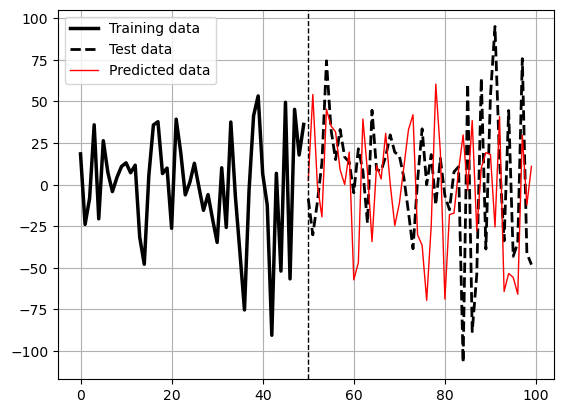

In [38]:
plot_train_test_values(100,50,y_train,y_test,y_predicted)
print("Accuracy Train = {:.2f}%".format(calculate_accuracy(y_predicted_train,y_train)))
print("Accuracy Test = {:.2f}%".format(calculate_accuracy(y_predicted,y_test)))
print("RMSE Train = {:.10f}".format(mean_squared_error(y_predicted_train, y_train)))
print("RMSE Test = {:.10f}".format(mean_squared_error(y_predicted, y_test)))
print("Model Bias = {:.2f}".format(model_bias(y_predicted)))

In [41]:
model = Sequential()
model.add(SimpleRNN(units = num_neurons_in_hidden_layers, input_shape = (num_lags, 1)))
model.add(Dense(num_neurons_in_hidden_layers, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, np.reshape(y_train, (-1,1)), epochs=num_epochs, batch_size=batch_size)
y_predicted_train = np.reshape(model.predict(x_train), (-1,1))
y_predicted = np.reshape(model.predict(x_test), (-1,1))

Epoch 1/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 981.4663
Epoch 2/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1016.7823
Epoch 3/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1063.1969
Epoch 4/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1041.4823
Epoch 5/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 986.9412
Epoch 6/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1141.5206
Epoch 7/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1082.1010
Epoch 8/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 985.3458
Epoch 9/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1001.6748
Epoch 10/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 946.9786
Epoch 11/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 988.1456
Epoch 12/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 901.5274
Epoch 13/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1053.9177
Epoch 14/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 853.8243
Epoch 15

Accuracy Train = 66.93%
Accuracy Test = 53.38%
RMSE Train = 640.1353980746
RMSE Test = 3444.3304342344
Model Bias = 1.38


/home/vuradok/Program_Works/master_function.py:174: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[0:first, 1] = plotting_time_series[0:first, 1] / 0
/home/vuradok/Program_Works/master_function.py:175: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[0:first, 2] = plotting_time_series[0:first, 2] / 0
/home/vuradok/Program_Works/master_function.py:176: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[first:, 0] = plotting_time_series[first:, 0] / 0


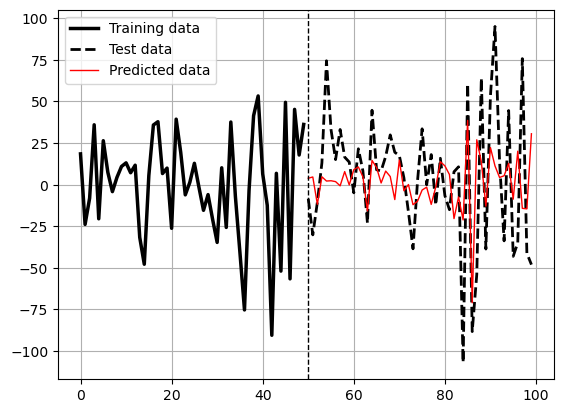

In [42]:
plot_train_test_values(100,50,y_train,y_test,y_predicted)
print("Accuracy Train = {:.2f}%".format(calculate_accuracy(y_predicted_train,y_train)))
print("Accuracy Test = {:.2f}%".format(calculate_accuracy(y_predicted,y_test)))
print("RMSE Train = {:.10f}".format(mean_squared_error(y_predicted_train, y_train)))
print("RMSE Test = {:.10f}".format(mean_squared_error(y_predicted, y_test)))
print("Model Bias = {:.2f}".format(model_bias(y_predicted)))

In [45]:
model = Sequential()
model.add(LSTM(units = num_neurons_in_hidden_layers, input_shape = (num_lags, 1)))
model.add(Dense(num_neurons_in_hidden_layers, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, np.reshape(y_train, (-1,1)), epochs=num_epochs, batch_size=batch_size)
y_predicted_train = np.reshape(model.predict(x_train), (-1,1))
y_predicted = np.reshape(model.predict(x_test), (-1,1))

Epoch 1/500


/home/vuradok/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 844.1033
Epoch 2/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1022.0579
Epoch 3/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 994.8559
Epoch 4/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 970.2881
Epoch 5/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 889.5029
Epoch 6/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 941.5556
Epoch 7/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 983.8824
Epoch 8/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 956.6945
Epoch 9/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 981.7864
Epoch 10/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 927.9680
Epoch 11/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 987.2333
Epoch 12/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1007.6315
Epoch 13/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 937.0408
Epoch 14/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 974.6246
Epoch 15/500
104/104 ━━━━

Accuracy Train = 78.66%
Accuracy Test = 52.17%
RMSE Train = 204.1565960683
RMSE Test = 6983.2276680168
Model Bias = 2.31


/home/vuradok/Program_Works/master_function.py:174: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[0:first, 1] = plotting_time_series[0:first, 1] / 0
/home/vuradok/Program_Works/master_function.py:175: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[0:first, 2] = plotting_time_series[0:first, 2] / 0
/home/vuradok/Program_Works/master_function.py:176: RuntimeWarning: invalid value encountered in divide
  plotting_time_series[first:, 0] = plotting_time_series[first:, 0] / 0


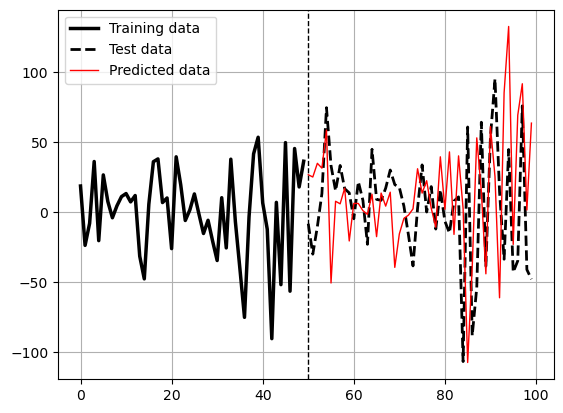

In [46]:
plot_train_test_values(100,50,y_train,y_test,y_predicted)
print("Accuracy Train = {:.2f}%".format(calculate_accuracy(y_predicted_train,y_train)))
print("Accuracy Test = {:.2f}%".format(calculate_accuracy(y_predicted,y_test)))
print("RMSE Train = {:.10f}".format(mean_squared_error(y_predicted_train, y_train)))
print("RMSE Test = {:.10f}".format(mean_squared_error(y_predicted, y_test)))
print("Model Bias = {:.2f}".format(model_bias(y_predicted)))

In [ ]:
model = Sequential()
model.add(GRU(units = num_neurons_in_hidden_layers, input_shape = (num_lags, 1)))
model.add(Dense(num_neurons_in_hidden_layers, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, np.reshape(y_train, (-1,1)), epochs=num_epochs, batch_size=batch_size)
y_predicted_train = np.reshape(model.predict(x_train), (-1,1))
y_predicted = np.reshape(model.predict(x_test), (-1,1))

Epoch 1/500


2024-10-20 00:31:03.017529: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 914.5655
Epoch 2/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 983.2938
Epoch 3/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 942.8948
Epoch 4/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1139.5131
Epoch 5/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 920.1823
Epoch 6/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 994.5062
Epoch 7/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 914.5206
Epoch 8/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 897.0911
Epoch 9/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 954.0195
Epoch 10/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1064.3451
Epoch 11/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 886.5710
Epoch 12/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1238.0416
Epoch 13/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 922.2840
Epoch 14/500
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 961.5533
Epoch 15/500
104/104 ━━━

In [1]:
plot_train_test_values(100,50,y_train,y_test,y_predicted)
print("Accuracy Train = {:.2f}%".format(calculate_accuracy(y_predicted_train,y_train)))
print("Accuracy Test = {:.2f}%".format(calculate_accuracy(y_predicted,y_test)))
print("RMSE Train = {:.10f}".format(mean_squared_error(y_predicted_train, y_train)))
print("RMSE Test = {:.10f}".format(mean_squared_error(y_predicted, y_test)))
print("Model Bias = {:.2f}".format(model_bias(y_predicted)))

NameError: name 'plot_train_test_values' is not defined

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from master_function import data_preprocessing, mass_import
from master_function import plot_train_test_values, forecasting_threshold

2024-10-21 22:10:50.599772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 22:10:50.699180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 22:10:50.699914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 22:10:50.858340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 22:10:51.920864: W tensorflow/compiler/tf

In [3]:
num_lags = 500
train_test_split = 0.80
num_neurons_in_hidden_layers = 256
num_epochs = 100
batch_size = 10
threshold = 0.0015

In [4]:
# Fetching the historical price data
data = np.diff(mass_import(0, 'D1')[:, 3])
# Creating the training and test sets

NameError: name 'mt5' is not defined